# Code Interpreting with OpenAI's o1 model
This example uses the E2B's [Code Interpreter](https://github.com/e2b-dev/code-interpreter) as a tool for OpenAI's o1 model. We ask o1 to generate Python code to train a machine learning model based on Kaggle's [Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) challenge and display the results in a graph.

We use two LLMs:
1. o1-mini to generate a thorough plan for the task with many code blocks
2. gpt-4o-mini to extract the final code from the plan generated by o1-mini

In [1]:
%pip install openai e2b_code_interpreter python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your OpenAI API key from https://platform.openai.com/api-keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")

O1_PROMPT = """You're a data scientist analyzing survival data from the Titanic Disaster. You are given tasks to complete and you run Python code to solve them.

Information about the Titanic dataset:
- It's in the `/home/user/train.csv` and `/home/user/test.csv` files
- The CSV files are using `,` as the delimiter
- They have following columns:
  - PassengerId: Unique passenger ID
  - Pclass: 1st, 2nd, 3rd (Ticket class)
  - Name: Passenger name
  - Sex: Gender
  - Age: Age in years
  - SibSp: Number of siblings/spouses aboard
  - Parch: Number of parents/children aboard
  - Ticket: Ticket number
  - Fare: Passenger fare
  - Cabin: Cabin number
  - Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Generally, you follow these rules:
- ALWAYS FORMAT YOUR RESPONSE IN MARKDOWN
- ALWAYS RESPOND ONLY WITH CODE IN CODE BLOCK LIKE THIS:
```python
{code}
```
- the python code runs in jupyter notebook.
- every time you generate python, the code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- install all packages before using by running `!pip install {package}`.
- you can run any python code you want, everything is running in a secure sandbox environment
"""

GPT_4O_PROMPT = "You are an expert software engineer that receives an execution plan, and then creates a single Python script that does everything in the plan. It will be executed in a single Python notebook cell."

In [3]:
import re
pattern = re.compile(r'```python\n(.*?)\n```', re.DOTALL)  # Match everything in between ```python and ```

def match_code_blocks(llm_response):
    matches = pattern.findall(llm_response)  # Find all matches
    if matches:
        code = "\n".join(matches)  # Concatenate all code blocks with newlines
        print("> LLM-generated code:")
        print(code)
        return code
    return ""

In [4]:
from openai import OpenAI

def chat(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  client = OpenAI(api_key=OPENAI_API_KEY)

  # First we get the plan from o1
  response_o1 = client.chat.completions.create(
    model="o1-mini",
    messages=[
      {"role": "user", "content": O1_PROMPT},
      {"role": "user", "content": user_message}
  ])
  content_o1 = response_o1.choices[0].message.content

  # Then we use gpt-4o-mini to extract the code from the plan we got from o1
  response_4o = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": GPT_4O_PROMPT},
        {"role": "user", "content": f"This is the plan I received, please write fully functional code that I can run in one notebook cell, and list all its dependencies: {content_o1}"},
  ])
  content_4o = response_4o.choices[0].message.content
  python_code = match_code_blocks(content_4o)

  if python_code != "":
    code_interpreter_results = code_interpret(e2b_code_interpreter, python_code)
    return code_interpreter_results
  else:
    print(f"Failed to match any Python code in model's response {content_4o}")
    return[]

In [5]:
def upload_dataset(code_interpreter):
  print("Uploading testing and training datasets to Code Interpreter sandbox...")
  with open("./test.csv", "rb") as f:
    remote_path = code_interpreter.upload_file(f)
    print("Uploaded test.csv at", remote_path)
  with open("./train.csv", "rb") as f:
    remote_path = code_interpreter.upload_file(f)
    print("Uploaded train.csv at", remote_path)

In [6]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

Uploading testing and training datasets to Code Interpreter sandbox...
Uploaded test.csv at /home/user/test.csv
Uploaded train.csv at /home/user/train.csv

User message: Clean the data, train a decision tree to predict the survival of passengers, and visualize the learning curve. Then run the model the test dataset and print the results.
> LLM-generated code:
# Install dependencies
!pip install pandas numpy scikit-learn matplotlib

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('/home/user/train.csv')
test_data = pd.read_csv('/home/user/test.csv')

# Combine train and test data for consistent preprocessing
train_data['TrainSplit'] = 'train'
test_data['Survived'] = np.nan  # Add Survived column to test data
test_data['TrainSplit'] =

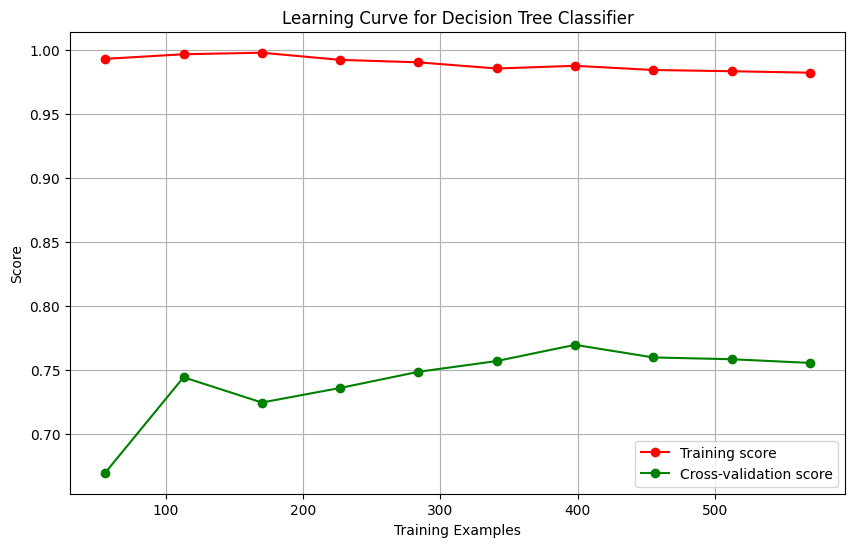

In [7]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat(
    code_interpreter,
    "Clean the data, train a decision tree to predict the survival of passengers, and visualize the learning curve. Then run the model the test dataset and print the results."
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code interpreter results")

first_result